## Code for fetching the MNIST Dataset.

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
#a DESCR key describing the dataset.
#a data key containing an array with one row per instance and one column per features.
#a target key containing an array with the labels.

In [3]:
x,y = mnist['data'],mnist['target']
print('shape of data :',x.shape, 'shape of trget :',y.shape)

shape of data : (70000, 784) shape of trget : (70000,)


#### There are 70,000 images and each image has 784 features. This is because each image is 28*28 pixels, and each features simply represents one pixel's intensity, from 0(white) to 255(black). let's take a peek at one digit from the dataset.


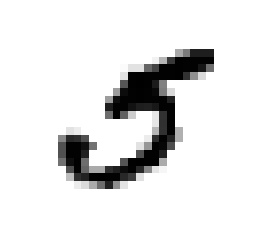

In [4]:
#grab an instance's feature vector, reshape it to a 28*28 array, and display it using Matplotlib's 'imshow()' function.

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = x[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

In [6]:
#the MNIST dataset is actually already split-up into training set(60,000 images) and a test set(last 10,000 images).
x_train,x_test,y_train,y_test = x[:60000],x[60000:],y[:60000],y[60000:]

#shuffleing of training data
import numpy as np
shuffle_index = np.random.permutation(60000)
x_train,y_train = x_train[shuffle_index],y_train[shuffle_index]

### Training a binary classifier.

In [7]:
#'5-detector' will be an example of a binary classifier which is capable to distinguishing between just two classes 5 and not -5.
#let's create the target variable for this classification task.

y_train_5 = (y_train == 5) #true for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [8]:
#let's create an SGDClassifier(stochastic gradient descent) and train it on the whole training set.

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42) #for reproducible results set 'random_state'
sgd_clf.fit(x_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [9]:
#detect the image of number 5.
sgd_clf.predict(some_digit)

C:\Users\MANISH\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ True], dtype=bool)

In [10]:
#The classifier guesses that this image represents a 5 (True).

## Performence measure.

### Measuring Accuracy Using Cross-Validation.

In [11]:
#A good way to evaluate a model is to use cross-validation.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3,random_state = 42)

for train_index,test_index in skfolds.split(x_train,y_train_5):
    clone_clf = clone(sgd_clf)
    
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    x_test_folds = x_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    n_correct = sum(y_test_folds == y_pred)
    print(n_correct/len(y_pred))

0.9634
0.9139
0.9403


In [12]:
#Evaluating SGDClassifier model using K-fold cross-validation.

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,x_train,y_train_5,cv = 3,scoring = 'accuracy')

array([ 0.9634,  0.9139,  0.9403])

##### Above two methods evaluate the same.

In [13]:
#Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the 
#evaluation scores, it returns the predictions made on each test fold.

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,x_train,y_train_5,cv = 3)

In [14]:
y_train_pred

array([False, False, False, ..., False, False, False], dtype=bool)

### Confusion Matrix.

In [15]:
#A much better way to evaluate the performance of a classifier is to look at the confusion matrix.

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_pred,y_train_5)

array([[51527,   596],
       [ 3052,  4825]])

##### Each row in a confusion matrix represents an 'actual class'  and each column represents 'predicted class'. 

##### The first row of this matrix considers 'negative class'(53171 were correctly classified (true negative) while 936 were wrongly classified(false positive)).

##### The 2nd row considered as 'positive class'(1408 wrongly classified(false negative) while remaining 4485 were correctly classified(true positive)).

In [16]:
#Acuracy of the positive prediction : Precision = TP/(TP+FP). here : TP = number of true positive, FP = number of false positive.

#Recall = TP/(TP+FN). here FN = number of false negative.

from sklearn.metrics import precision_score,recall_score
print('precision score :',precision_score(y_train_5,y_train_pred))
print('recall score :',recall_score(y_train_5,y_train_pred))

precision score : 0.612542846261
recall score : 0.890057185021


In [17]:
#our model can claims correct prediction only 76% and moreover it only detects 82% of the 5s.

#combination of precision and rcall into a single metric called the F1 score(simple way to compare two classifiers).
#f1 score = 2/((1/precision)+(1/recall)). i.e. harmonic mean of precision and recall. Hence a classifier will only get high f1 score 
#if both recall and precision are high.

from sklearn.metrics import f1_score
print('f1 score :',f1_score(y_train_5,y_train_pred))

f1 score : 0.725673033539


In [18]:
#precision/recall tradeoff = increasing precision reduces recall and vice-versa.

In [19]:
y_scores = sgd_clf.decision_function(([some_digit])) #decision_function let's us to set the threshold.
y_scores

array([ 133032.39910255])

In [20]:
threshold = 0
y_some_digit_pred = y_scores>threshold
y_some_digit_pred

array([ True], dtype=bool)

In [21]:
#The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold:

threshold = 200000
y_some_digit_pred = y_scores>threshold
y_some_digit_pred

array([False], dtype=bool)

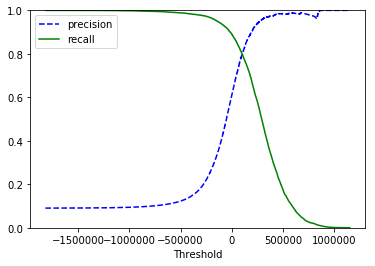

In [22]:
#This confirms that raising the threshold decreases recall.

#So how can you decide which threshold to use? For this you will first need to get the scores of all instances in the training 
#set using the cross_val_predict() function again, but this time specifying that you want it to return decision_scores instead of predictions:

y_scores = cross_val_predict(sgd_clf,x_train,y_train_5,cv = 3, method = 'decision_function')

#Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve() function:

from sklearn.metrics import precision_recall_curve
precision,recall,threshold = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_threshold(precision,recall,threshold):
    plt.plot(threshold,precision[:-1],'b--',label = 'precision')
    plt.plot(threshold,recall[:-1],'g-',label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precision,recall,threshold)
plt.show()

In [23]:
precision[:-1].shape,recall[:-1].shape

((59835,), (59835,))

In [24]:
precision.shape

(59836,)

In [25]:
recall.shape

(59836,)

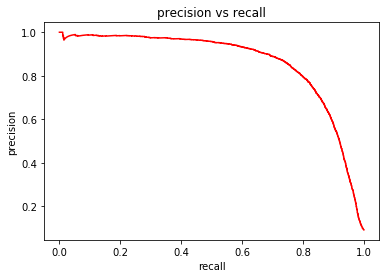

In [26]:
plt.plot(recall,precision,'r-',)
plt.title('precision vs recall')
plt.ylabel('precision')
plt.xlabel('recall')
plt.show()

In [27]:
#let's suppose to decide the to aim for 90% prcision.

y_train_pred_90 = y_scores > 70000

print('precision_score :', precision_score(y_train_5,y_train_pred_90))
print('recall_score :', recall_score(y_train_5,y_train_pred_90))

precision_score : 0.747759707932
recall_score : 0.831211953514


In [28]:
#A high precision classifier is not very useful if it's recall is too low.

### ROC(receiver operating characteristic) Curve.

##### The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate.

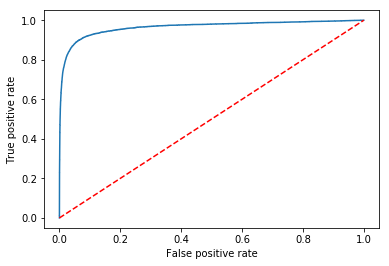

In [29]:
# The true Negative rate is also called 'specificity'.
# The true Positive rate(recall) is also called 'sensitivity'.
#To plot the ROC curve we first need to compute the TPR and FPRfor various threshold values,using the 'roc_curve()' function.

from sklearn.metrics import roc_curve

fpr,tpr,threshold = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'r--') #for plotting diagonal line
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
plot_roc_curve(fpr,tpr)
plt.show()

### ROC-AUC score.

In [30]:
#One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 
#1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores) #if you exchange the argument then it will throw an error.

0.96480727717146819

C:\Users\MANISH\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


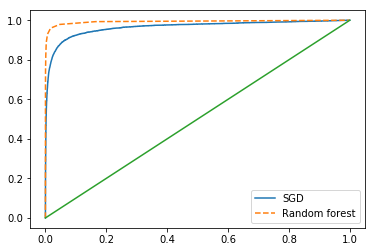

In [31]:
#let's train a RandomForestClassifier and compare it's ROC curve and ROC AUC score to the SGDClassifier.

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf,x_train,y_train_5,cv = 3,method = 'predict_proba')

#to plot a ROC curve, we needs score not probabilities so for this:
y_scores_forest = y_probas_forest[:,1] # score = probability of positive class
fpr_forest,tpr_forest,threshold_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr,"-",label = 'SGD')
plt.plot(fpr_forest,tpr_forest,'--',label = 'Random forest')
plt.plot([0,1],[0,1])
plt.legend(loc = 'bottom right')
plt.show();

In [32]:
#here the RandomForestClassifier's ROC curve looks much better than the SGD curve because it is more towards the top left corner and resulting more area under the curve.
#ROC-AUC score

roc_auc_score(y_train_5,y_scores_forest)

0.99298816657872857

In [33]:
#wooha it's not bad!


### Conclusion : We know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs, and compare various models using ROC curves and ROC AUC scores.

## Multiclass classification.

In [33]:
#Two methods. 1. one vs all(OvA) 2.one vs one(OvO).
#in ovo method if there are N classes then we need to train N*(N-1)/2 classifiers.

#Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically 
#runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier:

sgd_clf.fit(x_train,y_train) #y_train, not y_train_5. Here y_train takes values from 0 to 9.
sgd_clf.predict([some_digit])

array([ 5.])

In [34]:
#decision_function() got their decision scores for the image, and select the class with highest score.

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-175100.72139368, -492923.59858644, -380013.46787443,
        -181720.90446791, -273263.81272353,  133032.39910255,
        -815401.90428359, -274705.94476715, -553490.86038151,
        -368610.69651883]])

In [35]:
#The highest score indeed the one crossponding to class 5 i.e. 149654.78228365 .

print('maximum value :',np.max(some_digit_scores),', crossponding to digit :',np.argmax(some_digit_scores))

maximum value : 133032.399103 , crossponding to digit : 5


In [36]:
#if we want to force scikit-learn to use one-versus-one or one-versus-all, we can use the 'OneVsOneClassifier' or 'OneVsRestClassifier' classes..
#Simply create an intense and pass a binary classifier to it's constructor.
#For example, this code creates a multi-class classifier using the OvO strategy, based on a SGDClassifier:

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(x_train,y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [37]:
#Training a RandomForestClassifier.

forest_clf.fit(x_train,y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [38]:
#This time scikit-learn did not have to run OvA or OvO because Random Forest classifier can directly classify instances into multiple classes.
#we can call the 'predict_proba()' to get the list of probabilities that the classifier assigned to each instance for each class:

forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0.2,  0. ,  0.7,  0. ,  0. ,  0.1,  0. ]])

In [39]:
#here model confident about it's prediction : probabilities for predict the number 5 is 0.9 .

# let's evaluate the SGDClassifier's accuracy using the cross_val_score() function

cross_val_score(sgd_clf,x_train,y_train,cv = 3, scoring = 'accuracy')

array([ 0.87992402,  0.85164258,  0.87678152])

In [40]:
#here accuracy is approc 88% on all test folds. To increase accuracy we will use simply scaling inputs.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf,x_train_scaled,y_train, cv = 3, scoring = 'accuracy')

array([ 0.90956809,  0.90954548,  0.91088663])

In [46]:
#here we can see that the accuracy has increased after feature scaling.

## Error Analysis.

##### Error Analysis is a way to improve model's accuracy by analysing types of error it makes.

In [41]:
#exploring data preparation options, trying out multiple models, shortlisting the best ones and fine-tuning their hyperparameters
#using GridSearchCV, and automating as much as possible is the basic process.

#We need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function.
y_train_pred = cross_val_predict(sgd_clf,x_train_scaled,y_train, cv = 3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5729,    2,   30,    8,   14,   46,   43,    8,   42,    1],
       [   1, 6489,   46,   26,    7,   35,    9,    8,  111,   10],
       [  53,   34, 5322,  107,   83,   25,   96,   56,  165,   17],
       [  51,   41,  138, 5362,    1,  213,   33,   56,  141,   95],
       [  26,   28,   37,   12, 5372,    7,   54,   30,   76,  200],
       [  74,   41,   36,  192,   80, 4590,  114,   27,  173,   94],
       [  32,   26,   45,    2,   44,   77, 5639,    7,   46,    0],
       [  26,   21,   76,   29,   66,    9,    6, 5822,   16,  194],
       [  49,  152,   79,  160,   14,  146,   52,   25, 5023,  151],
       [  44,   33,   30,   91,  177,   27,    3,  214,   78, 5252]])

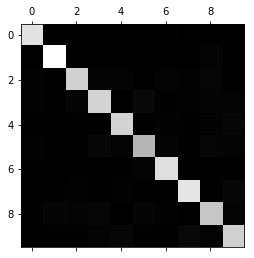

In [42]:
#alternative way to represent the confusion matrix using Matplotlib's matshow() function.

plt.matshow(conf_mx,cmap = plt.cm.gray)
plt.show()

In [49]:
#Let’s focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the 
#corresponding class, so we can compare error rates instead of absolute number of errors.

row_sums = conf_mx.sum(axis = 1)
norm_conf_mx = conf_mx/row_sums
row_sums

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

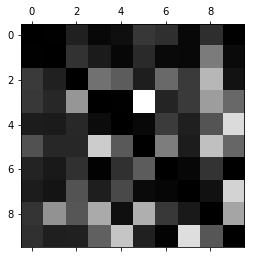

In [50]:
#Now let's fill the diagonal with zeros to keep only the errors, and let's plot the result:

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap = plt.cm.gray)
plt.show()

##### Now we can clearly see the kinds of errors the classifier makes.
##### Here rows represent actual classes, while columns represent predicted classes. 
##### The columns for classes 8 and 9 are quite bright, which tells that many images get misclassified as  8s or 9s. Similarly, the rows for classes 8 and 9 are also quite bright, telling you that 8s and 9s are often confused with other digits. Conversely, some rows are pretty dark, such as row 1: this means that most 1s are classified correctly (a few are confused with 8s, but that’s about it). 
##### Notice that the errors are not perfectly symmetrical; for example, there are more 5s misclassified as 8s than the reverse.

In [51]:
#Analyzing the confusion matrix can often give insights on ways to improve your classifier. Looking at this plot, it seems 
#that the efforts should be spent on improving classification of 8s and 9s, as well as fixing the specific 3/5 confusion.